In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
import datetime
import math
import uproot
import ROOT
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
import scipy.integrate as intg 
from scipy.stats import norm
from numpy.random import normal
import sipm.recon.WaveformAnalyzer as wfa
import sipm.recon.WaveformDataset as wfd
import sipm.util.functions as func

plt.style.use('darkside')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

Welcome to JupyROOT 6.26/08


## Visualize waveforms from original binary files

/scratch/gpfs/GALBIATI/data/sipm//xenon_doping/2023-12-22/2023-12-22_volt_96_light_scintillation_source_co60_xenon_0_cond_gamma/0/wave0.dat
9312 events
/scratch/gpfs/GALBIATI/data/sipm//xenon_doping/2023-12-22/2023-12-22_volt_96_light_scintillation_source_co60_xenon_0_cond_gamma/0/wave1.dat
9312 events
/scratch/gpfs/GALBIATI/data/sipm//xenon_doping/2023-12-22/2023-12-22_volt_96_light_scintillation_source_co60_xenon_0_cond_gamma/0/wave2.dat
9312 events
/scratch/gpfs/GALBIATI/data/sipm//xenon_doping/2023-12-22/2023-12-22_volt_96_light_scintillation_source_co60_xenon_0_cond_gamma/0/wave3.dat
9312 events
/scratch/gpfs/GALBIATI/data/sipm//xenon_doping/2023-12-22/2023-12-22_volt_96_light_scintillation_source_co60_xenon_0_cond_gamma/0/wave4.dat
9312 events
/scratch/gpfs/GALBIATI/data/sipm//xenon_doping/2023-12-22/2023-12-22_volt_96_light_scintillation_source_co60_xenon_0_cond_gamma/0/wave5.dat
9312 events
/scratch/gpfs/GALBIATI/data/sipm//xenon_doping/2023-12-22/2023-12-22_volt_96_light_scint

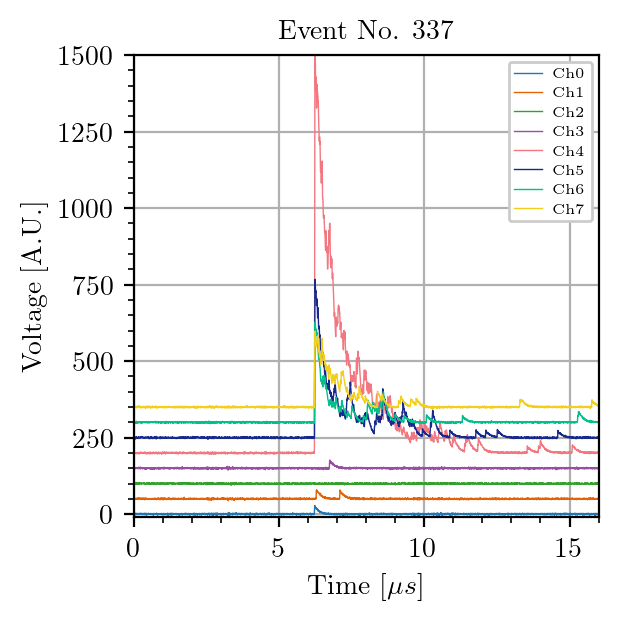

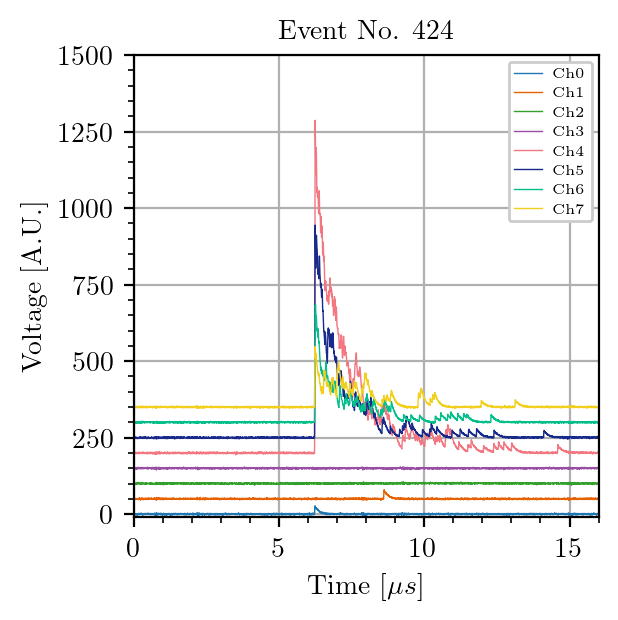

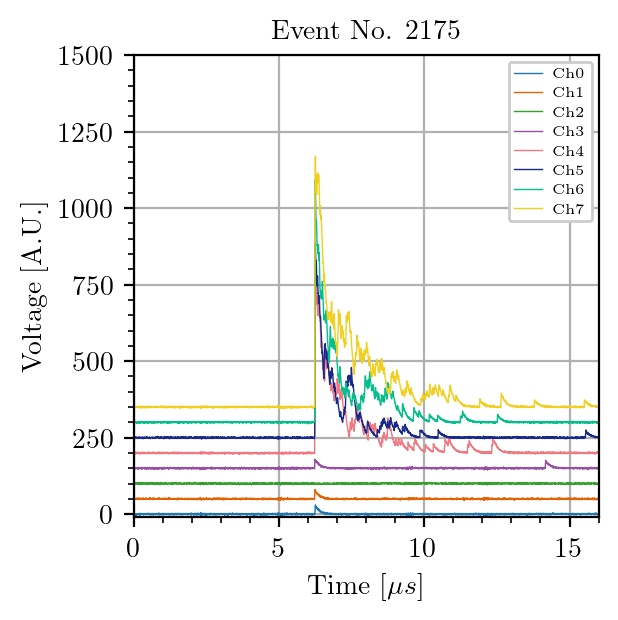

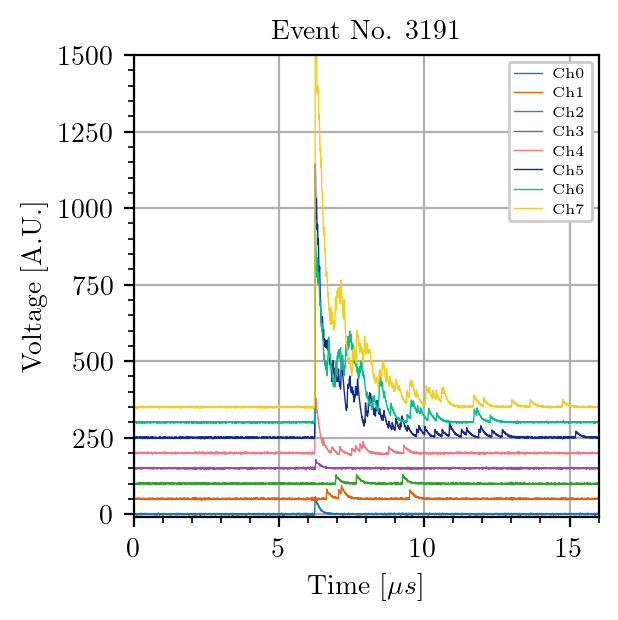

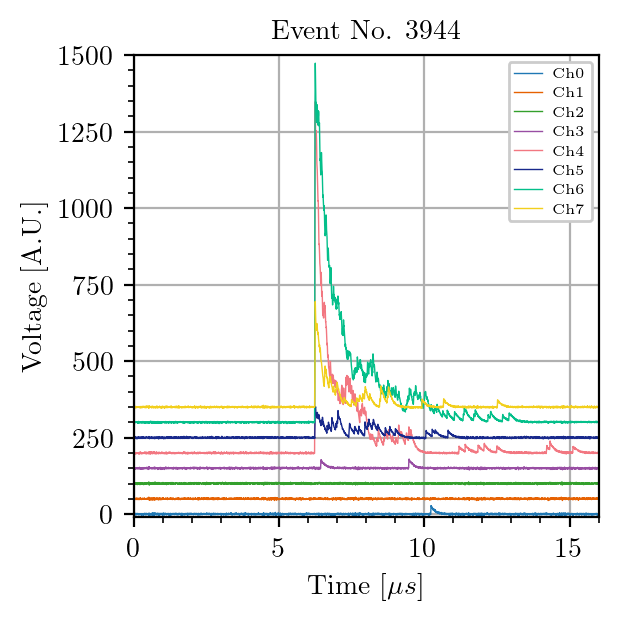

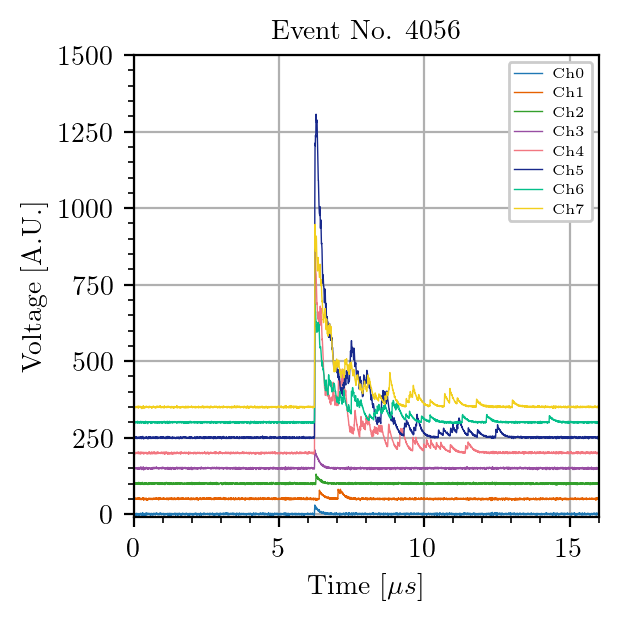

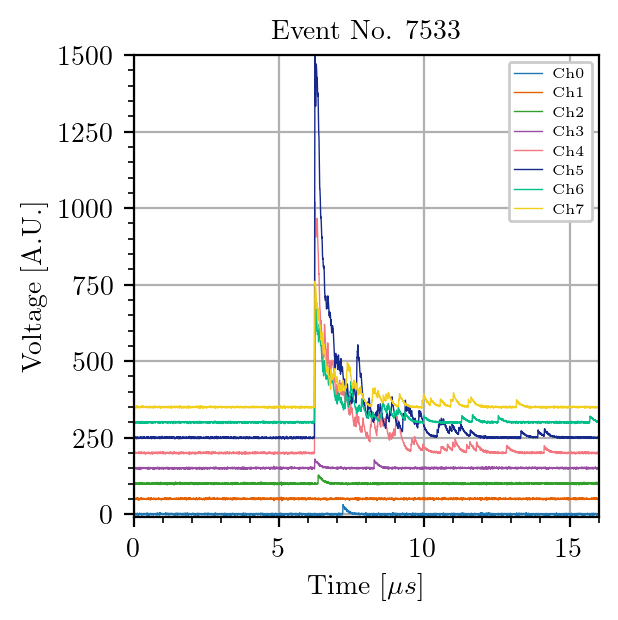

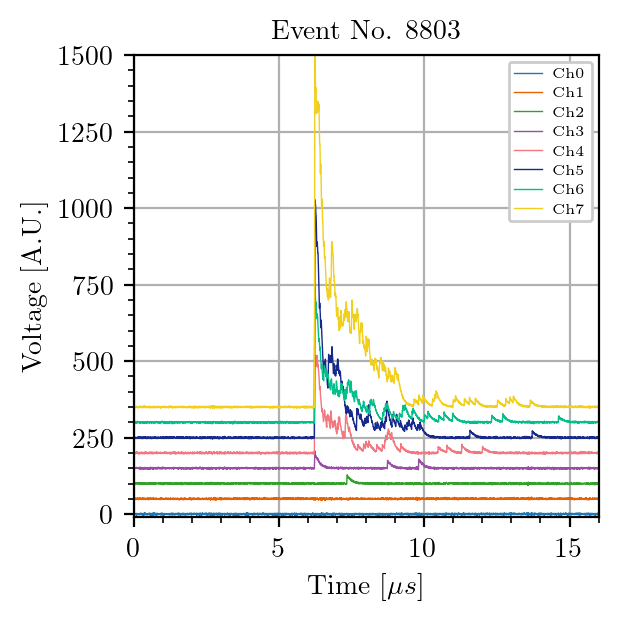

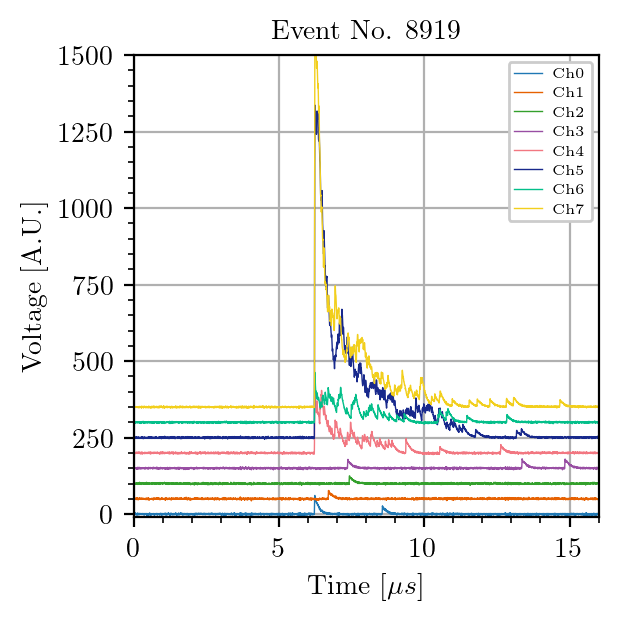

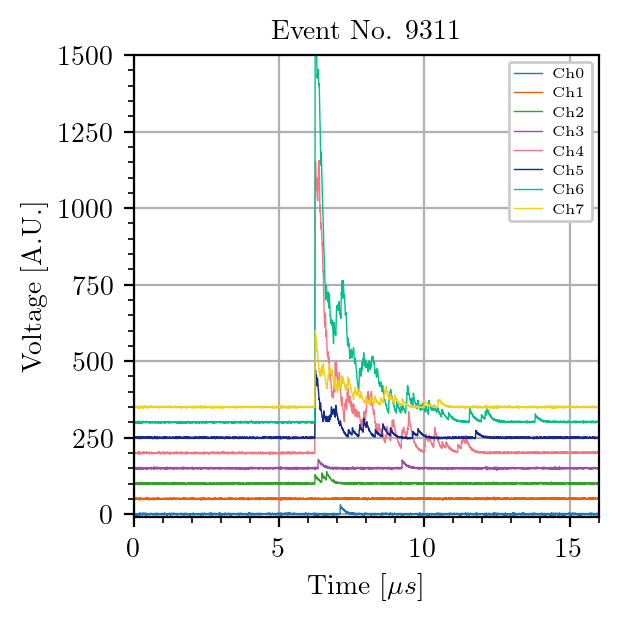

In [2]:
data_dir = '/scratch/gpfs/GALBIATI/data/sipm/xenon_doping/'
direc = '2023-12-22/2023-12-22_volt_96_light_scintillation_source_co60_xenon_0_cond_gamma/0/'
# evid = np.arange(0, 10)
# evid = [3,25,42,48,49,56,65,96,105,123]
evid = [337,424,2175,3191,3944,4056,7533,8803,8919,9311]
dset = wfd.WaveformDataset(path='{}{}'.format(data_dir, direc), pol=-1, channels=range(8))
wfs = []
for ch in np.arange(8):
    wfs.append(dset.ch[ch].get_waveforms(ev=evid, ar_filter=False)[0])
wfs = np.array(wfs)
print(wfs.shape)
for i in range(wfs.shape[1]):
    plt.figure(i, figsize=(3, 3))
    for ch in range(wfs.shape[0]):
        plt.plot(dset.ch[ch].time, wfs[ch,i]+ch*50, label=f'Ch{ch}', linewidth=0.5)
    plt.legend(loc='upper right', fontsize=5)
    plt.xlabel(r'Time [$\mu s$]')
    plt.ylabel(r'Voltage [A.U.]')
    plt.minorticks_on()
    plt.grid()
    plt.xlim(0, 16)
    plt.ylim(-10, 1500)
    plt.title(f'Event No. {evid[i]}')

## List pre-processed h5 files

In [3]:
path = "/scratch/gpfs/as111/results/"
date = '2023-12-22'
files = [[],[]] # Co-60, backgrounds
files[0].extend(glob(f"{path}{date}/*cond_gamma*scintillation_pulse_liq5.h5"))
files[1].extend(glob(f"{path}{date}/*cond_backgrounds*scintillation_pulse_liq5.h5"))
print(len(files[0]), files[0])
print(len(files[1]), files[1])

20 ['/scratch/gpfs/as111/results/2023-12-22/2023-12-22_volt_96_light_scintillation_cond_gamma_run16_scintillation_pulse_liq5.h5', '/scratch/gpfs/as111/results/2023-12-22/2023-12-22_volt_96_light_scintillation_cond_gamma_run9_scintillation_pulse_liq5.h5', '/scratch/gpfs/as111/results/2023-12-22/2023-12-22_volt_96_light_scintillation_cond_gamma_run17_scintillation_pulse_liq5.h5', '/scratch/gpfs/as111/results/2023-12-22/2023-12-22_volt_96_light_scintillation_cond_gamma_run14_scintillation_pulse_liq5.h5', '/scratch/gpfs/as111/results/2023-12-22/2023-12-22_volt_96_light_scintillation_cond_gamma_run10_scintillation_pulse_liq5.h5', '/scratch/gpfs/as111/results/2023-12-22/2023-12-22_volt_96_light_scintillation_cond_gamma_run2_scintillation_pulse_liq5.h5', '/scratch/gpfs/as111/results/2023-12-22/2023-12-22_volt_96_light_scintillation_cond_gamma_run18_scintillation_pulse_liq5.h5', '/scratch/gpfs/as111/results/2023-12-22/2023-12-22_volt_96_light_scintillation_cond_gamma_run8_scintillation_pulse_l

## Load h5 files

In [4]:
# data folder
data = {}
date_time = {}
channels = np.arange(-1,8) # channel -1 contains total_pe and fprompt
volt = 96
cond = ['Co-60', 'Backgrounds']
for i, c in enumerate(cond):
    data[c] = {}
    for ch in channels:
        data[c][ch] = []
        for f in files[i]:
            df = pd.read_hdf(f, key=f'{volt}/{ch}')
            data[c][ch].append(df)
            df = None
        data[c][ch] = pd.concat(data[c][ch]).sort_index()
        if ch!=-1:
            data[c][ch].rename(columns=lambda x: x+f'_{ch}',inplace=True)
    data[c] = pd.concat(list(data[c].values()),axis=1)
print(f'{data[cond[0]].shape[0]} Co-60 events')
print(f'{data[cond[1]].shape[0]} background events')
print('columns: ', list(data[cond[0]].columns))

1007180 Co-60 events
99744 background events
columns:  ['start_datetime', 'end_datetime', 'duration_seconds', 'nch', 'nch_top', 'nch_bot', 'total_pe', 'fprompt_0p30us_01234567', 'fprompt_0p30us_0123', 'fprompt_0p30us_4567', 'baseline_mean_0', 'baseline_rms_0', 'integral_0p30us_0', 'integral_5p00us_0', 'fired_0', 'amplitude_0', 'peakpos_0', 'baseline_mean_1', 'baseline_rms_1', 'integral_0p30us_1', 'integral_5p00us_1', 'fired_1', 'amplitude_1', 'peakpos_1', 'baseline_mean_2', 'baseline_rms_2', 'integral_0p30us_2', 'integral_5p00us_2', 'fired_2', 'amplitude_2', 'peakpos_2', 'baseline_mean_3', 'baseline_rms_3', 'integral_0p30us_3', 'integral_5p00us_3', 'fired_3', 'amplitude_3', 'peakpos_3', 'baseline_mean_4', 'baseline_rms_4', 'integral_0p30us_4', 'integral_5p00us_4', 'fired_4', 'amplitude_4', 'peakpos_4', 'baseline_mean_5', 'baseline_rms_5', 'integral_0p30us_5', 'integral_5p00us_5', 'fired_5', 'amplitude_5', 'peakpos_5', 'baseline_mean_6', 'baseline_rms_6', 'integral_0p30us_6', 'integral_

## Read calibration file

In [5]:
calib = pd.read_hdf('data/calibration_liq5_2023-12-13.h5', key=f'{volt}V')
calib

,channel,A1min,A1max,DiCT,DiCT_err,Qavg,Qavg_err,Qpeak,Qpeak_err,Qap,Qap_err,bsl_rms,fano
0,0,169.50,543.25,0.046332,0.003478,1164.728477,1.304297,1131.491681,3.416132,0.028013,0.003161,2.0,1.077587
1,1,153.25,517.25,0.049100,0.001656,1144.683208,1.851095,1113.892448,1.097667,0.026285,0.001851,2.0,1.077368
2,2,153.25,517.25,0.049479,0.001834,1154.966355,1.610303,1122.321809,1.350212,0.027647,0.001801,2.0,1.081956
3,3,150.00,510.75,0.043612,0.005856,1150.263808,2.583902,1117.967777,2.060560,0.027628,0.002859,2.0,1.073662
4,4,114.25,413.25,0.032734,0.002590,916.492212,2.721177,904.480062,2.866587,0.012846,0.004256,2.0,1.051267
5,5,130.50,429.50,0.058036,0.002614,912.401287,1.673212,898.871298,1.559696,0.014179,0.002414,2.0,1.073896
6,6,140.25,436.00,0.033369,0.005075,904.286389,1.489399,892.146274,1.304836,0.013154,0.002158,2.0,1.052321
7,7,133.75,442.50,0.031540,0.003544,915.056285,0.928691,902.121780,0.788094,0.013886,0.001315,2.0,1.049422


In [6]:
convert_pe = calib['Qavg']/(1-calib['DiCT'])
convert_pe

0    1221.314176
1    1203.789652
2    1215.088282
3    1202.716963
4     947.507911
5     968.615772
6     935.503021
7     944.857202
dtype: float64

## Compute PEs of top and bottom SiPMs

In [7]:
pe_ch = {}
for c in cond:
    pe_ch[c] = data[c][[f'integral_5p00us_{ch}' for ch in range(8)]]
    pe_ch[c].columns = np.arange(8)
    pe_ch[c] = pe_ch[c]/convert_pe
    data[c]['top_pe'], data[c]['bot_pe'] = pe_ch[c].iloc[:,-4:].sum(axis=1), pe_ch[c].iloc[:,:4].sum(axis=1)
    pe_ch[c] = None

## Baseline cut
Same baseline cut as calibration data (baseline std $<1.8$ ADC units). Cut fraction higher.

In [8]:
# Initialize container
baseline = {}
for c in cond:
    baseline[c] = {}
    for ch in channels:
        baseline[c][ch] = {}

In [9]:
# Produce baseline rms histograms
nbins = 500
range_min = 0
range_max = 10
for c in cond:
    for ch in channels[1:]:
        baseline[c][ch]['rms_counts'], baseline[c][ch]['rms_bins'] = np.histogram(data[c][f'baseline_rms_{ch}'], bins=nbins, range=(range_min, range_max))

In [10]:
# Produce baseline mean histograms
nbins = 500
range_min = 3800
range_max = 4000
rms_threshold = {cond[0]:[1.8]*8,cond[1]:[1.8]*8}
for c in cond:
    for ch in channels[1:]:
        data[c][f'bsl_filt_{ch}'] = data[c][f'baseline_rms_{ch}']<rms_threshold[c][ch]
        baseline[c][ch]['mean_counts'], baseline[c][ch]['mean_bins'] = np.histogram(
            data[c][f'baseline_mean_{ch}'], 
            bins=nbins, range=(range_min, range_max)
        )
        baseline[c][ch]['mean_counts_filt'], baseline[c][ch]['mean_bins_filt'] = np.histogram(
            data[c].loc[data[c][f'bsl_filt_{ch}'],f'baseline_mean_{ch}'], # cut on baseline rms
            bins=nbins, range=(range_min, range_max)
        )

In [11]:
# Print container keys
print('baseline keys: ', list(
    baseline[cond[0]][0].keys()))

baseline keys:  ['rms_counts', 'rms_bins', 'mean_counts', 'mean_bins', 'mean_counts_filt', 'mean_bins_filt']


Text(0.07, 0.5, 'Count')

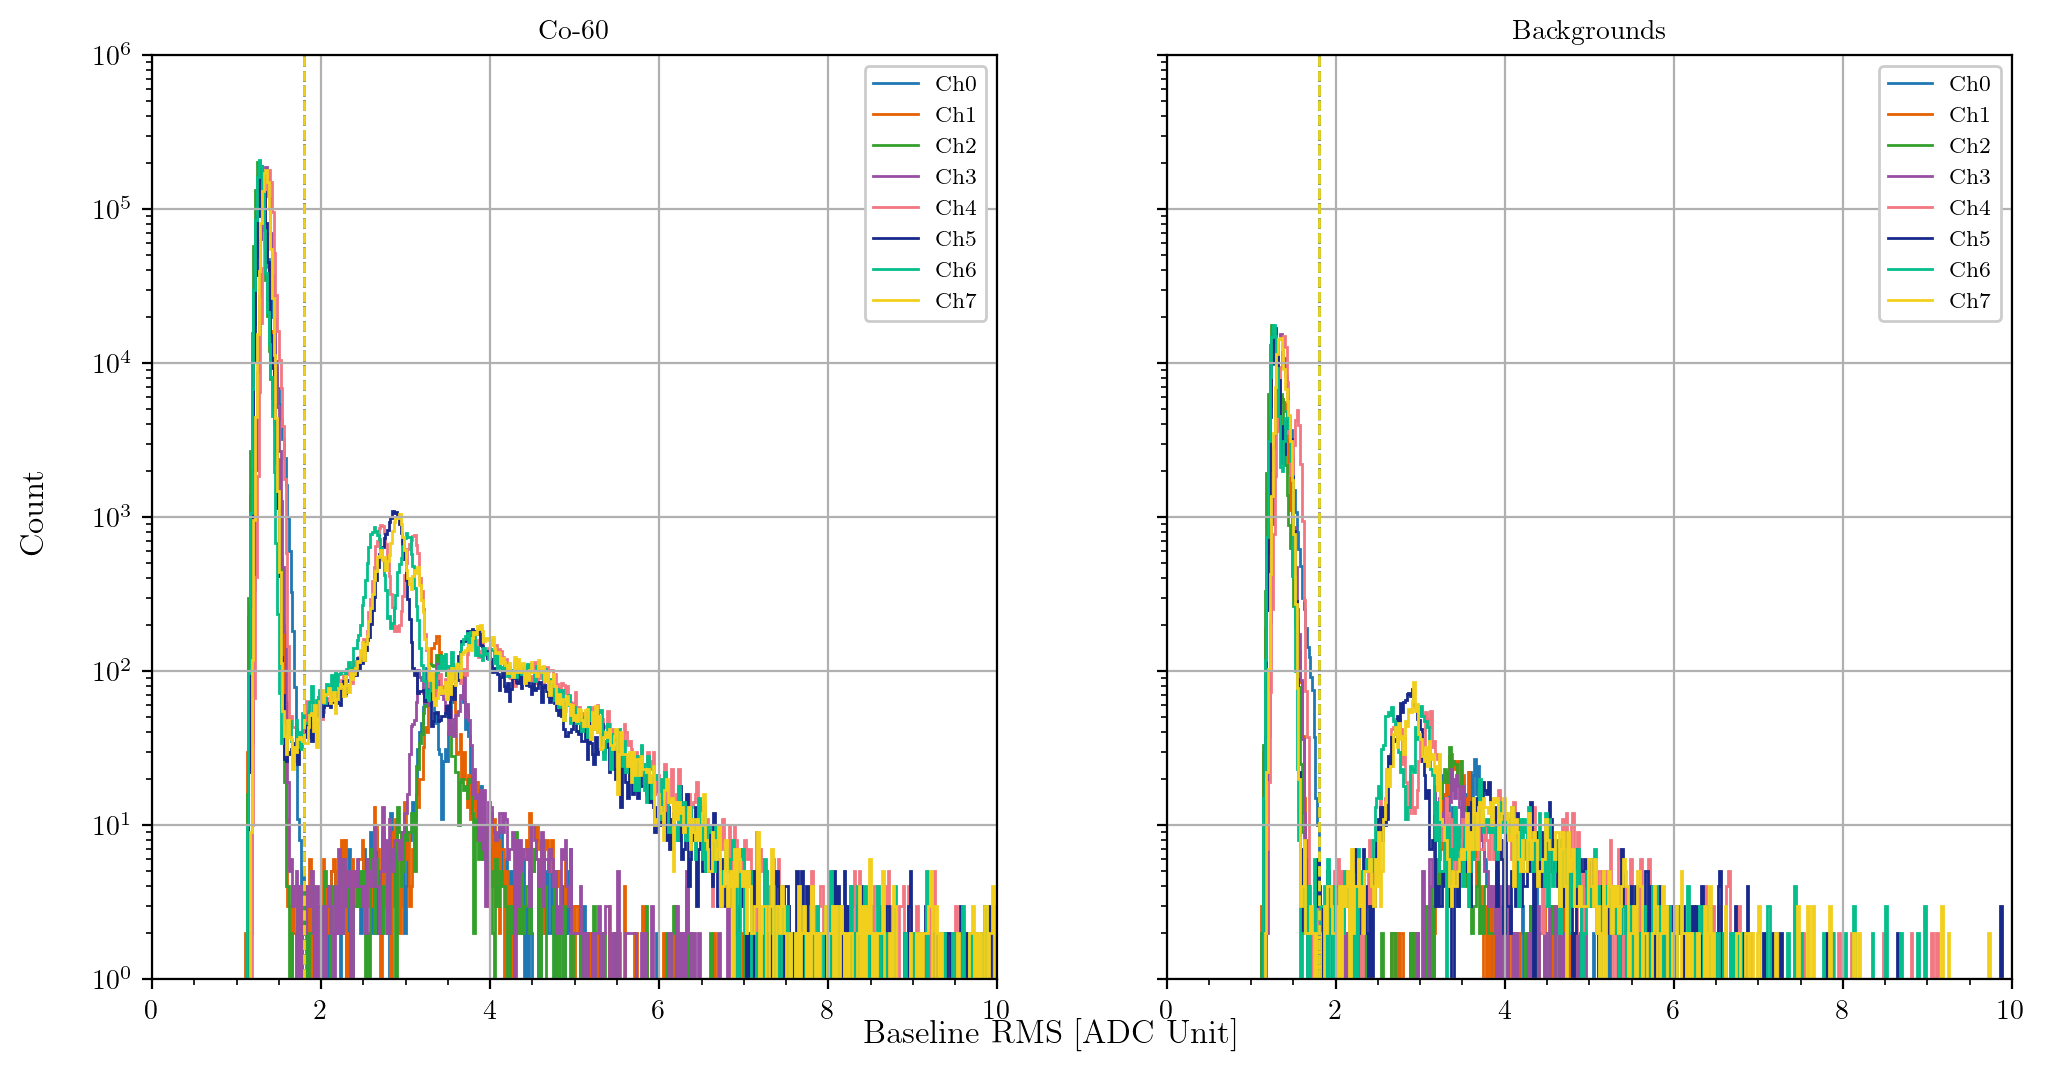

In [12]:
# Make plots for all datasets
# Baseline RMS
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
fig.set_size_inches(12, 6)
for i, c in enumerate(cond):
    for j, ch in enumerate(channels[1:]):
        axs[i].stairs(
            baseline[c][ch]['rms_counts'],
            baseline[c][ch]['rms_bins'],
            label=f'Ch{ch}', color=f'C{j}'
        )
        th = rms_threshold[c][ch]
        axs[i].plot([th, th], [1, 1e6], f'C{j}--', linewidth=1)
    axs[i].legend(loc='upper right')
    axs[i].set_ylim(1, 1e6)
    axs[i].set_yscale('log')
    axs[i].minorticks_on()
    axs[i].grid()
    axs[i].set_title(f'{c}')
fig.supxlabel('Baseline RMS [ADC Unit]', y=0.05)
fig.supylabel('Count', x=0.07)

Text(0.07, 0.5, 'Count')

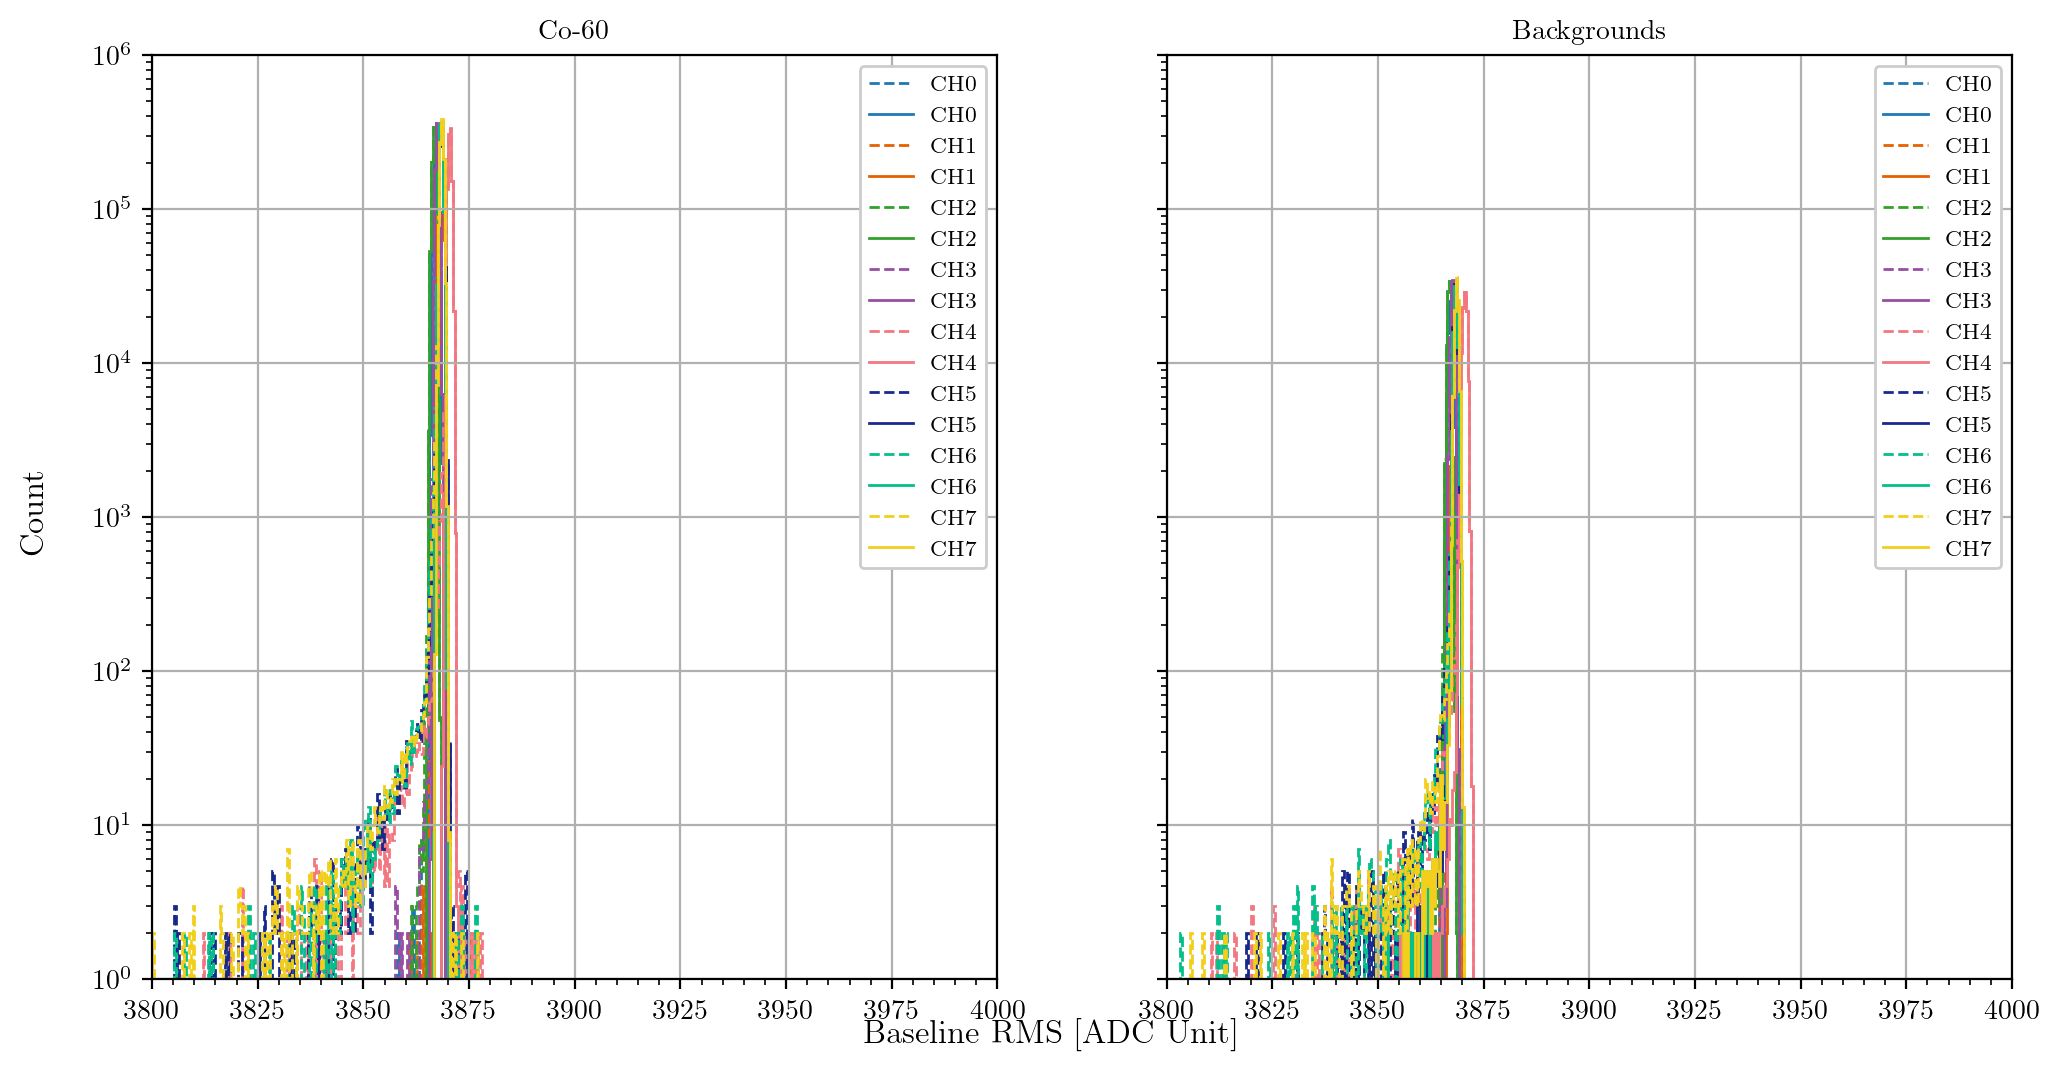

In [13]:
# Make plots for all datasets
# Baseline mean
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
fig.set_size_inches(12, 6)
for i, c in enumerate(cond):
    for j, ch in enumerate(channels[1:]):
        axs[i].stairs(
            baseline[c][ch]['mean_counts'],
            baseline[c][ch]['mean_bins'],
            label=f'CH{ch}', color=f'C{j}', linestyle='--'
        )
        axs[i].stairs(
            baseline[c][ch]['mean_counts_filt'],
            baseline[c][ch]['mean_bins_filt'],
            label=f'CH{ch}', color=f'C{j}'
        )
    axs[i].legend(loc='upper right')
    axs[i].set_ylim(1, 1e6)
    axs[i].set_yscale('log')
    axs[i].minorticks_on()
    axs[i].grid()
    axs[i].set_title(f'{c}')
fig.supxlabel('Baseline RMS [ADC Unit]', y=0.05)
fig.supylabel('Count', x=0.07)

Plots for Co-60 ch0


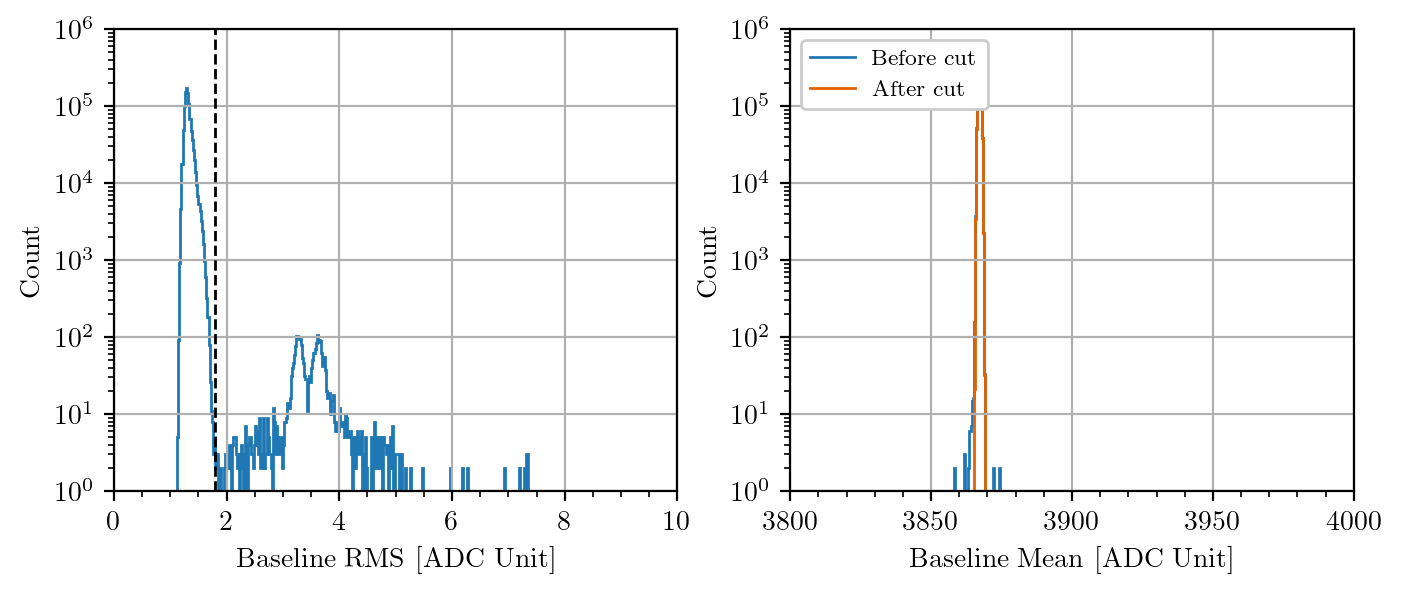

In [14]:
# Make plots for selected dataset
ch = 0
c = cond[0]
print(f'Plots for {c} ch{ch}')
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(8, 3)

# rms
axs[0].stairs(baseline[c][ch]['rms_counts'],
              baseline[c][ch]['rms_bins'])
th = rms_threshold[c][ch]
axs[0].plot([th, th], [1, 1e6], 'k--', linewidth=1)
axs[0].set_ylim(1, 1e6)
axs[0].set_yscale('log')
axs[0].set_xlabel('Baseline RMS [ADC Unit]')
axs[0].set_ylabel('Count')
axs[0].minorticks_on()
axs[0].grid()

# mean
axs[1].stairs(baseline[c][ch]['mean_counts'],
              baseline[c][ch]['mean_bins'],
              label='Before cut')
axs[1].stairs(baseline[c][ch]['mean_counts_filt'],
              baseline[c][ch]['mean_bins_filt'],
              label='After cut')
axs[1].legend()
axs[1].set_yscale('log')
axs[1].set_ylim(1, 1e6)
axs[1].set_xlim(3800, 4000)
axs[1].set_xlabel('Baseline Mean [ADC Unit]')
axs[1].set_ylabel('Count')
axs[1].minorticks_on()
axs[1].grid()

## Saturated peaks
Find maximum amplitude and remove those events reaching maximum amplitude.

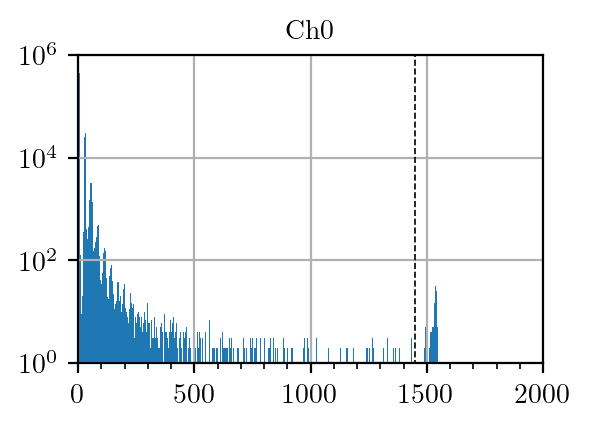

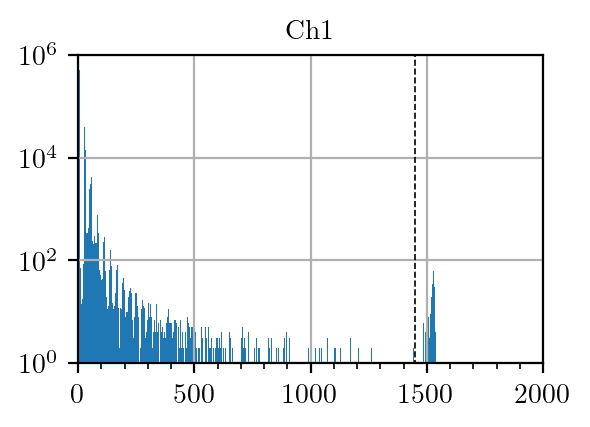

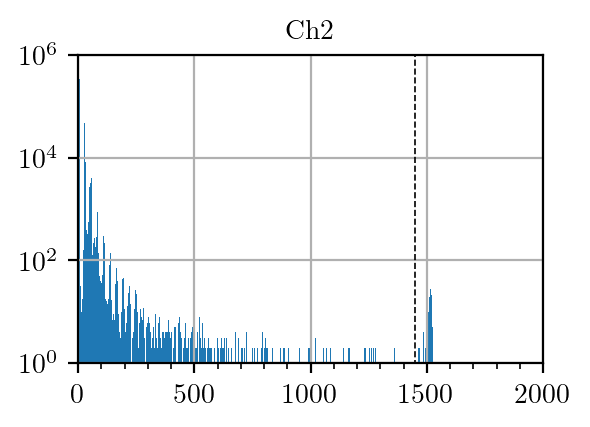

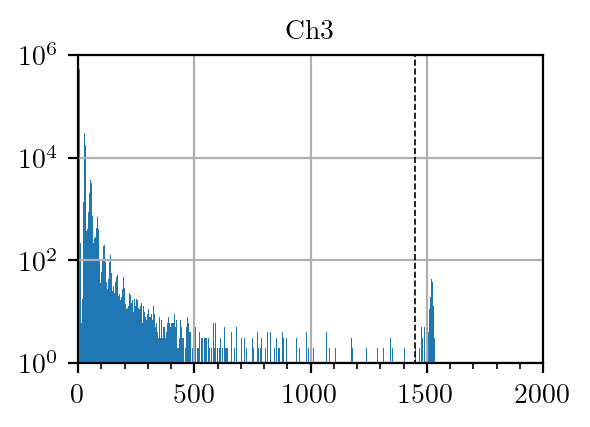

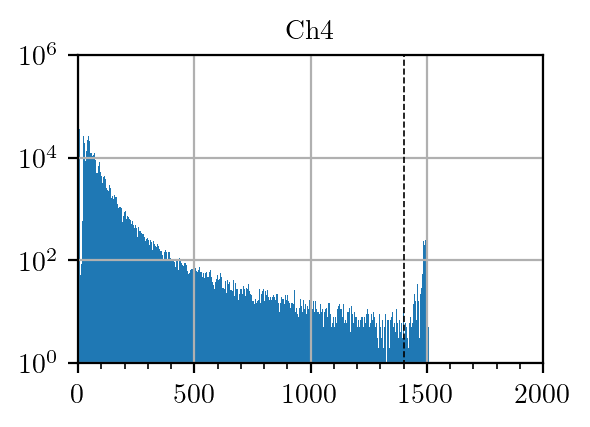

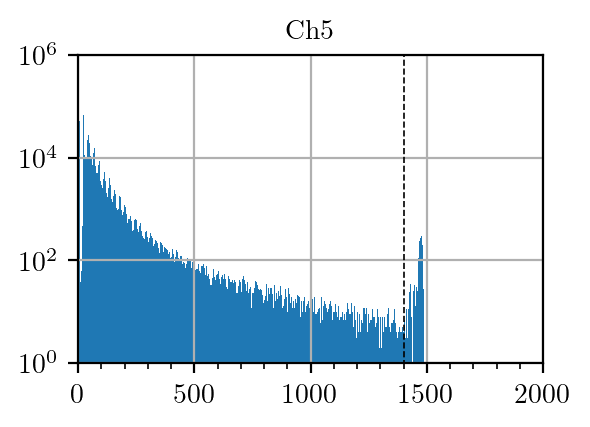

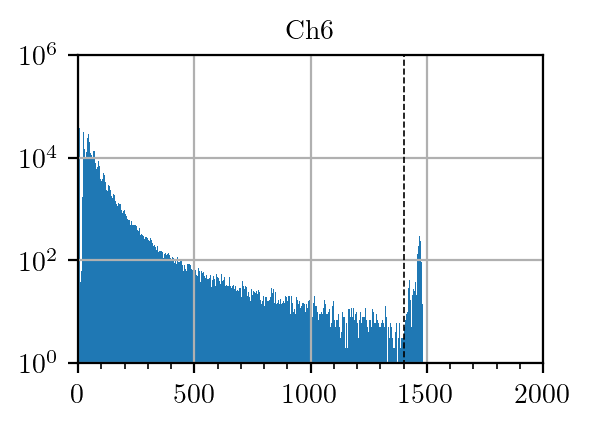

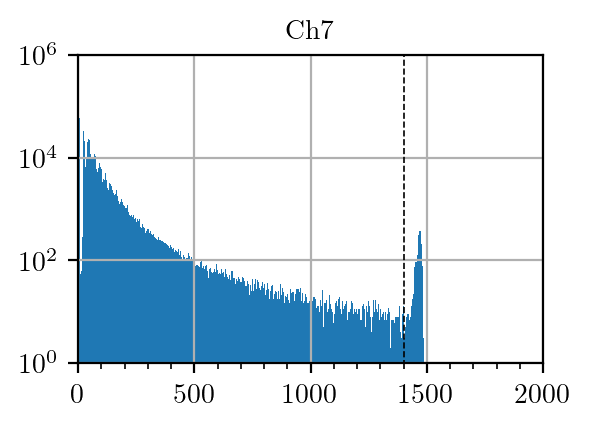

In [15]:
amp_sat = [1450]*4+[1400]*4
for ch in channels[1:]:
    plt.figure(ch,figsize=(3,2))
    plt.hist(data[cond[0]][f'amplitude_{ch}'],bins=np.linspace(0,1600,1000))
    plt.plot([amp_sat[ch]]*2,[0,1e6],'k--',linewidth=0.6)
    plt.title(f'Ch{ch}')
    plt.yscale('log')
    plt.grid()
    plt.minorticks_on()
    plt.ylim(0,1e6)
for c in cond:
    for ch in channels[1:]:
        data[c][f'sat_filt_{ch}'] = data[c][f'amplitude_{ch}']<amp_sat[ch]

## Fprompt cut
$F_{\rm prompt}$ is defined as the prompt ($0.3~\rm \mu s$) integral divided by the full ($5~\rm \mu s$) integral.
The ER band of $F_{\rm prompt}\sim0.3$ is clearly visible.
Yet some events have $F_{\rm prompt}\simeq0$, likely due to events triggered on noise with a delayed scintillation pulse.
These are rejected by requiring $F_{\rm prompt}>0.1$.

In [16]:
# Initialize container
fprompt = {}
positions = ['all','top','bottom']
for c in cond:
    fprompt[c] = {}
    for p in positions:
        fprompt[c][p] = {}

In [17]:
# Produce fprompt 2D histograms
nbinsx = 500
range_minx = -10
range_maxx = 600
nbinsy = 500
range_miny = 0
range_maxy = 1

for c in cond:
    data[c]['bsl_filt'] = data[c][[f'bsl_filt_{ch}' for ch in range(8)]].all(axis=1)
    data[c]['sat_filt'] = data[c][[f'sat_filt_{ch}' for ch in range(8)]].all(axis=1)
    filt = data[c]['bsl_filt'] & data[c]['sat_filt']
    fprompt[c]['all']['fp_counts'], fprompt[c]['all']['fp_xbins'], fprompt[c]['all']['fp_ybins'] = np.histogram2d(
        data[c]['total_pe'][filt], 
        data[c]['fprompt_0p30us_01234567'][filt], 
        bins=[nbinsx,nbinsy], range=[[range_minx,range_maxx],[range_miny,range_maxy]]
    )
    fprompt[c]['top']['fp_counts'], fprompt[c]['top']['fp_xbins'], fprompt[c]['top']['fp_ybins'] = np.histogram2d(
        data[c]['top_pe'][filt], 
        data[c]['fprompt_0p30us_4567'][filt], 
        bins=[nbinsx,nbinsy], range=[[range_minx,range_maxx],[range_miny,range_maxy]]
    )
    fprompt[c]['bottom']['fp_counts'], fprompt[c]['bottom']['fp_xbins'], fprompt[c]['bottom']['fp_ybins'] = np.histogram2d(
        data[c]['bot_pe'][filt], 
        data[c]['fprompt_0p30us_0123'][filt], 
        bins=[nbinsx,nbinsy], range=[[range_minx,range_maxx/3],[range_miny,range_maxy]]
    )
    for p in positions:
        fprompt[c][p]['fp_counts'] = fprompt[c][p]['fp_counts'].T
        fprompt[c][p]['fp_xbins'], fprompt[c][p]['fp_ybins'] = np.meshgrid(
            fprompt[c][p]['fp_xbins'], fprompt[c][p]['fp_ybins']
        )
        fprompt[c][p]['fp_threshold'] = 0.1
    data[c]['fp_filt'] = data[c]['fprompt_0p30us_01234567']>fprompt[c]['all']['fp_threshold']
    data[c]['all_filt'] = data[c][['bsl_filt','sat_filt','fp_filt']].all(axis=1)

Text(0.07, 0.5, '$F_{\\rm 0.3\\mu s}$ (Nbot=4)')

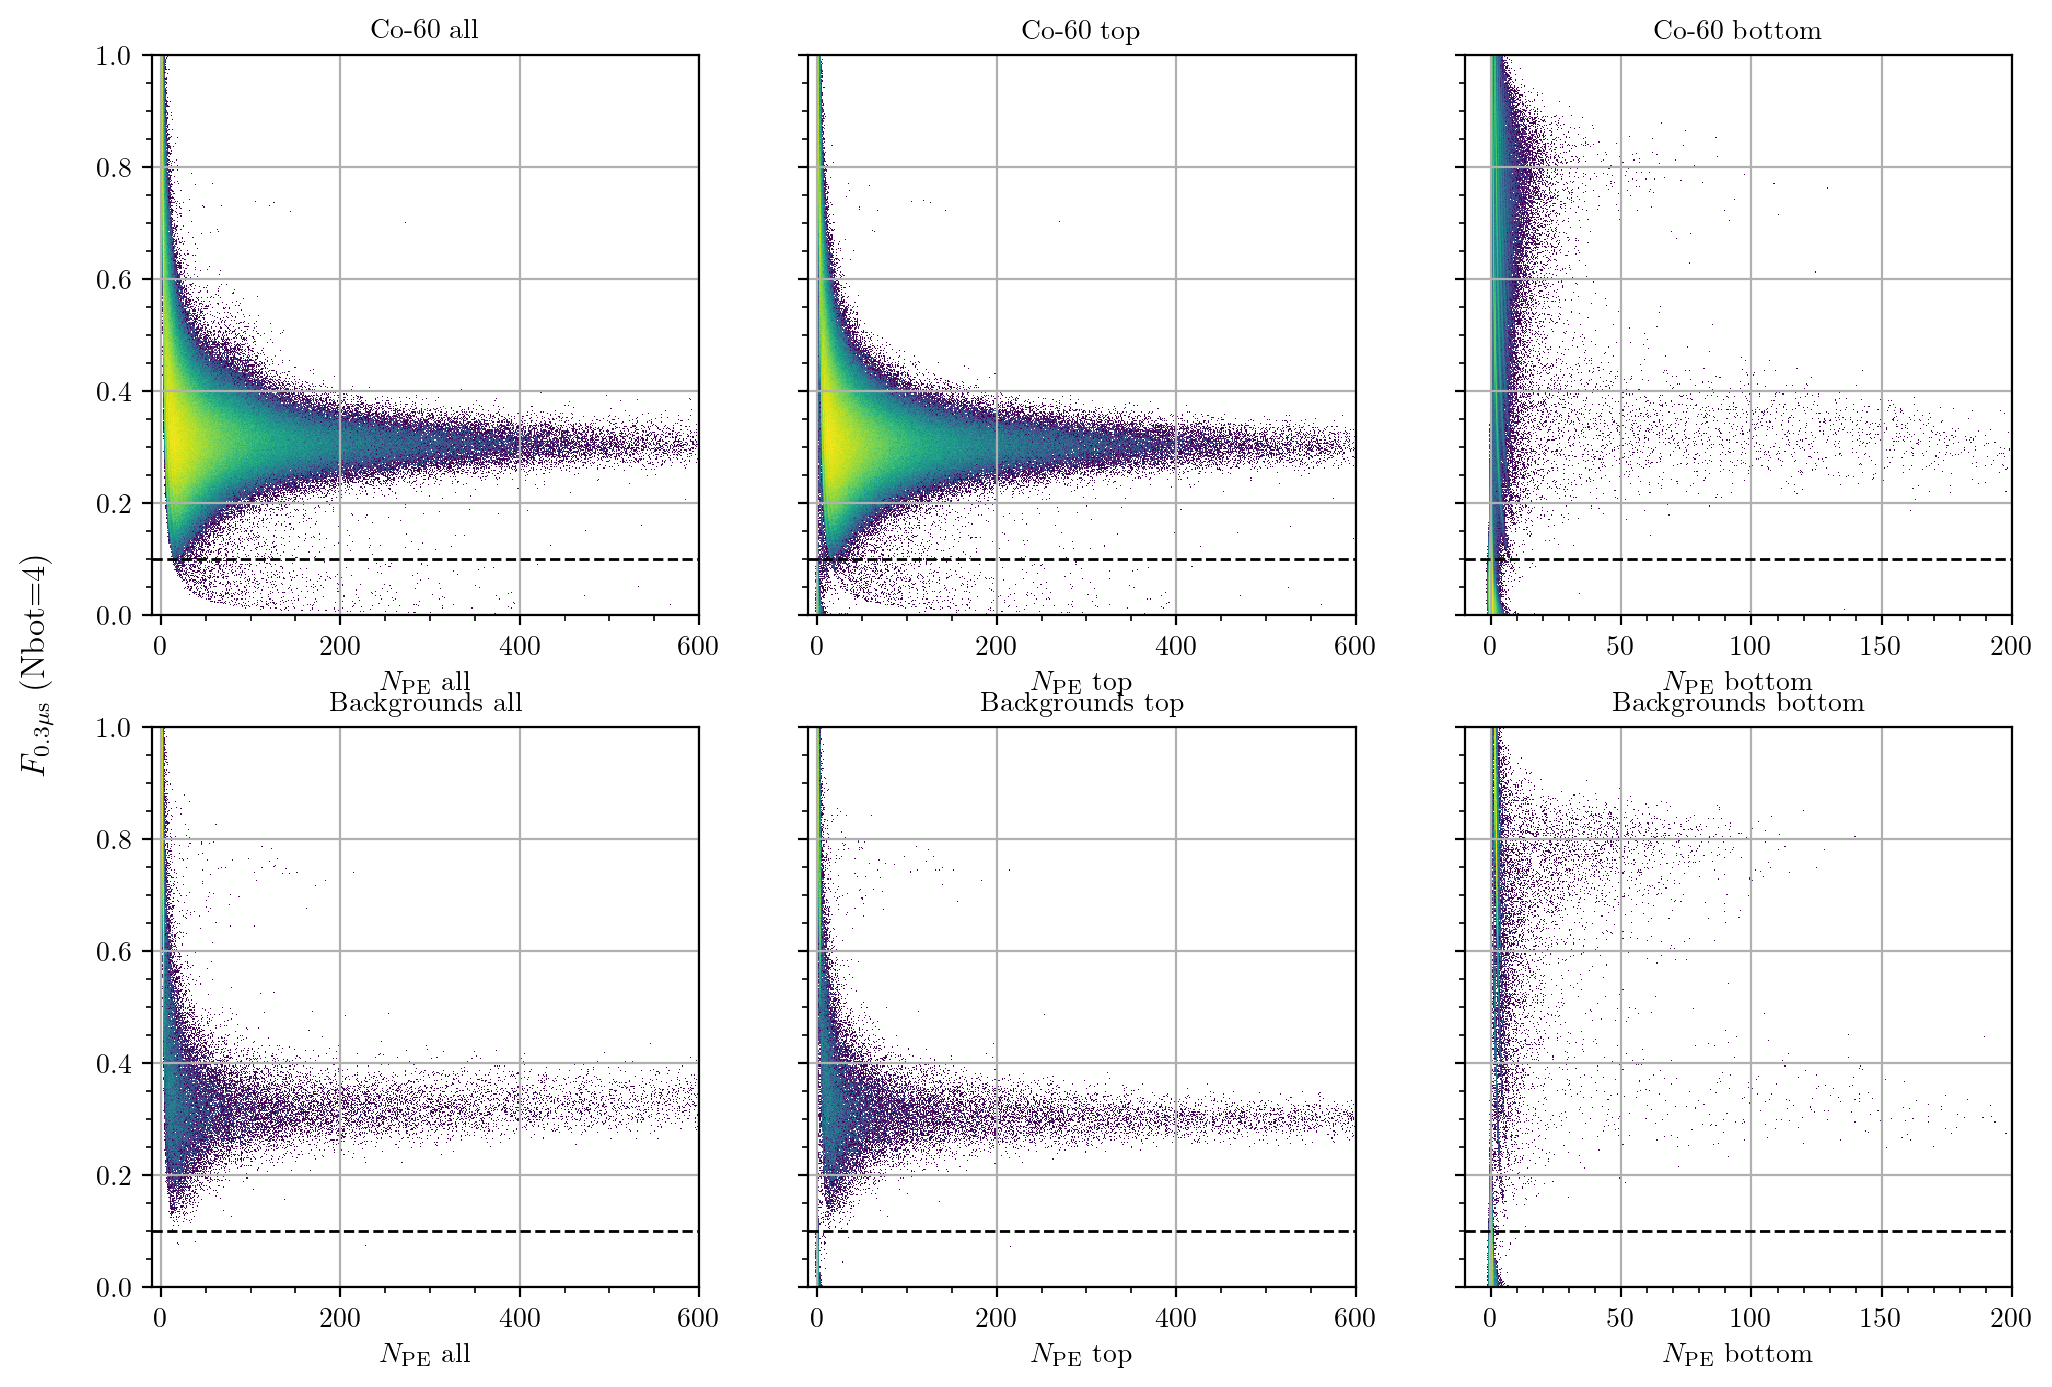

In [18]:
# Make plots for all datasets
# Fprompt
fig, axs = plt.subplots(2, 3, sharex=False, sharey=True)
fig.set_size_inches(12, 8)
for i, c in enumerate(cond):
    for j, p, in enumerate(positions):
        axs[i,j].pcolormesh(
            fprompt[c][p]['fp_xbins'],
            fprompt[c][p]['fp_ybins'],
            np.log10(fprompt[c][p]['fp_counts'])
        )
        th = fprompt[c][p]['fp_threshold']
        if p=='bottom':
            axs[i,j].plot([-10, range_maxx/3], [th, th], f'k--', linewidth=1)
            axs[i,j].set_xlim(-10, range_maxx/3)
        else:
            axs[i,j].plot([-10, range_maxx], [th, th], f'k--', linewidth=1)
            axs[i,j].set_xlim(-10, range_maxx)
        axs[i,j].minorticks_on()
        axs[i,j].grid()
        axs[i,j].set_title(f'{c} {p}')
        axs[i,j].set_xlabel(r'$N_{\rm PE}$ ' + p)
fig.supylabel(r'$F_{\rm 0.3\mu s}$ (Nbot=4)', x=0.07)

In [19]:
# Print container keys
print('fprompt keys: ', list(
    fprompt[cond[0]].keys()))

fprompt keys:  ['all', 'top', 'bottom']


## Event ID selection

In [20]:
sel = (data['Co-60']['total_pe']>500) & (data['Co-60']['total_pe']<600) & data['Co-60']['all_filt']
ev_id = data['Co-60'][sel].index[:10].get_level_values(1).to_numpy()
print(ev_id)
data['Co-60'][sel]

[ 337  424 2175 3191 3944 4056 7533 8803 8919 9311]


start_datetime  end_datetime  duration_seconds  nch  nch_top  \
run event                                                                 
0   337               NaN           NaN               NaN    7        4   
    424               NaN           NaN               NaN    6        4   
    2175              NaN           NaN               NaN    7        4   
    3191              NaN           NaN               NaN    8        4   
    3944              NaN           NaN               NaN    6        4   
...                   ...           ...               ...  ...      ...   
19  40442             NaN           NaN               NaN    7        4   
    42504             NaN           NaN               NaN    7        4   
    43248             NaN           NaN               NaN    5        4   
    48675             NaN           NaN               NaN    5        4   
    49329             NaN           NaN               NaN    7        4   

           nch_bot    total_pe  fprompt_0p30us_01234567  fprompt_0p30us_0123  \
run event                                                                      
0   337          3  524.598615                 0.290036             0.472771   
    424          2  525.362461                 0.264916             0.347807   
    2175         3  566.788746                 0.295871             0.784532   
    3191         4  529.807174                 0.303422             0.244226   
    3944         2  503.230597                 0.312898             0.184905   
...            ...         ...                      ...                  ...   
19  40442        3  507.620353                 0.343884             0.607679   
    42504        3  527.418033                 0.309705             0.270205   
    43248        1  518.277601                 0.321469             0.329580   
    48675        1  524.498881                 0.304730             0.009538   
    49329        3  506.775471                 0.316370             0.472660   

           fprompt_0p30us_4567  ...  sat_filt_2  sat_filt_3  sat_filt_4  \
run event                       ...                                       
0   337               0.288589  ...        True        True        True   
    424               0.264508  ...        True        True        True   
    2175              0.292467  ...        True        True        True   
    3191              0.304760  ...        True        True        True   
    3944              0.313648  ...        True        True        True   
...                        ...  ...         ...         ...         ...   
19  40442             0.341768  ...        True        True        True   
    42504             0.309966  ...        True        True        True   
    43248             0.321436  ...        True        True        True   
    48675             0.305145  ...        True        True        True   
    49329             0.315230  ...        True        True        True   

           sat_filt_5  sat_filt_6  sat_filt_7  bsl_filt  sat_filt  fp_filt  \
run event                                                                    
0   337          True        True        True      True      True     True   
    424          True        True        True      True      True     True   
    2175         True        True        True      True      True     True   
    3191         True        True        True      True      True     True   
    3944         True        True        True      True      True     True   
...               ...         ...         ...       ...       ...      ...   
19  40442        True        True        True      True      True     True   
    42504        True        True        True      True      True     True   
    43248        True        True        True      True      True     True   
    48675        True        True        True      True      True     True   
    49329        True        True        True      True      True     True   

   

## Top-Bottom 2D Distribution
Use the boxed region to determine background scaling factor.

In [21]:
nbinsx = 500
range_minx = -50
range_maxx = 1000
nbinsy = 500
range_miny = -50
range_maxy = 300

top_bot_pe = {}
for c in cond:
    top_bot_pe[c] = {}
    top_bot_pe[c]['counts'], top_bot_pe[c]['xbins'], top_bot_pe[c]['ybins'] = np.histogram2d(
        data[c]['top_pe'][data[c]['all_filt']], 
        data[c]['bot_pe'][data[c]['all_filt']], 
        bins=[nbinsx,nbinsy], range=[[range_minx,range_maxx],[range_miny,range_maxy]]
    )
    top_bot_pe[c]['counts'] = top_bot_pe[c]['counts'].T
    top_bot_pe[c]['xbins'], top_bot_pe[c]['ybins'] = np.meshgrid(
        top_bot_pe[c]['xbins'], top_bot_pe[c]['ybins']
    )

Backgrounds to be scaled by 0.13785180930499713


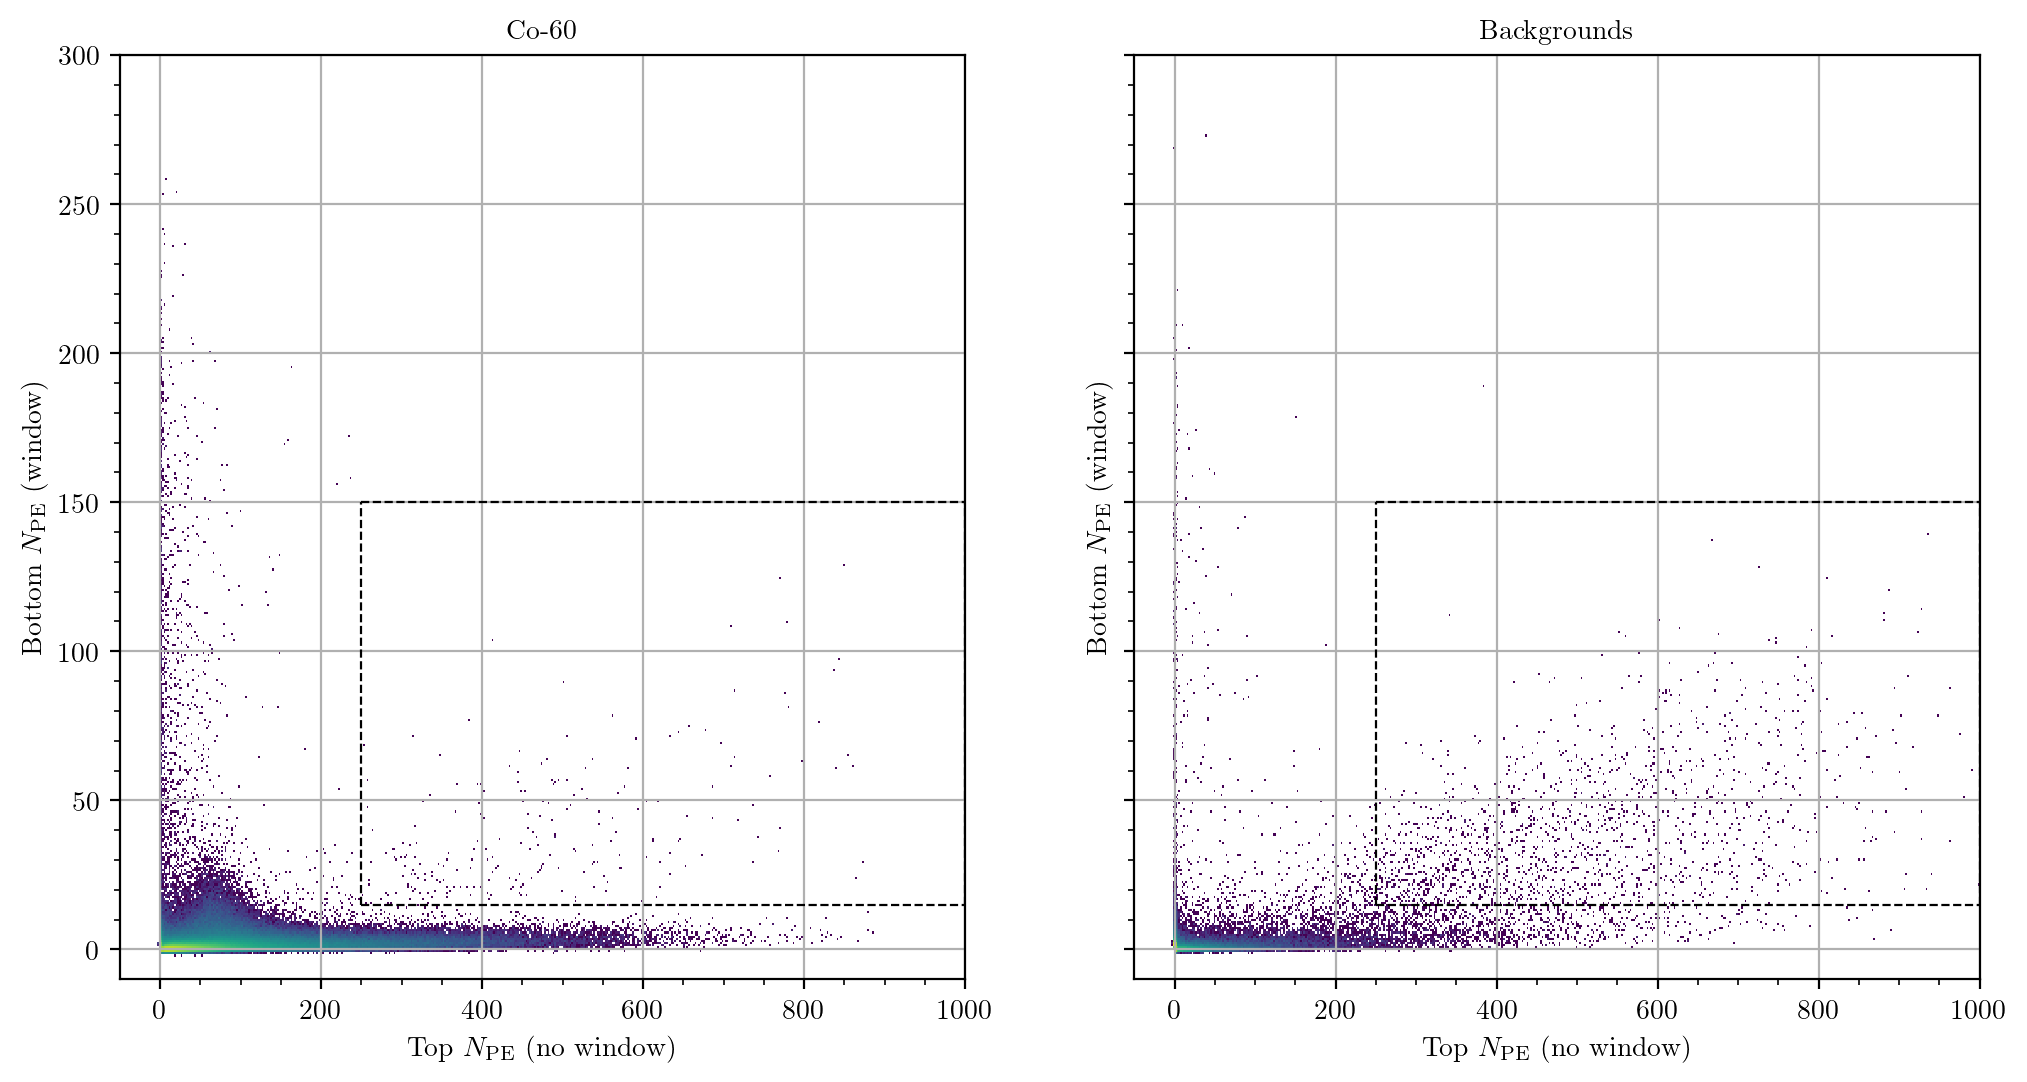

In [22]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
fig.set_size_inches(12, 6)
x1, y1, x2, y2 = 250, 15, 1000, 150
for i, c in enumerate(cond):
    axs[i].pcolormesh(
        top_bot_pe[c]['xbins'],
        top_bot_pe[c]['ybins'],
        np.log10(top_bot_pe[c]['counts'])
    )
    axs[i].minorticks_on()
    axs[i].grid()
    axs[i].set_title(f'{c}')
    axs[i].set_xlim(-50, 1000)
    axs[i].set_ylim(-10, 300)
    axs[i].set_xlabel(r'Top $N_{\rm PE}$ (no window)')
    axs[i].set_ylabel(r'Bottom $N_{\rm PE}$ (window)')
    axs[i].plot([x1,x1], [y1,y2], 'k--', linewidth=0.8)
    axs[i].plot([x2,x2], [y1,y2], 'k--', linewidth=0.8)
    axs[i].plot([x1,x2], [y1,y1], 'k--', linewidth=0.8)
    axs[i].plot([x1,x2], [y2,y2], 'k--', linewidth=0.8)

mask_x, mask_y = (top_bot_pe[c]['xbins'][0,1:]<x2)&(top_bot_pe[c]['xbins'][0,1:]>x1), (top_bot_pe[c]['ybins'][1:,0]<y2)&(top_bot_pe[c]['ybins'][1:,0]>y1)
bkg_scale = np.sum(top_bot_pe[cond[0]]['counts'][mask_y][:,mask_x])/np.sum(top_bot_pe[cond[1]]['counts'][mask_y][:,mask_x])
print(f'Backgrounds to be scaled by {bkg_scale}')

# Backgrounds and Co-60 Data

## Draw spectra
The PE count $N_{\rm PE}$ is reconstructed as
$$N_{\rm PE}=\frac{I}{Q_{\rm avg}/(1-p)}$$
where $I$ is the time integral ($5~\rm\mu s$) of the unfiltered waveform.
Ideally, this corrects for the direct crosstalk and afterpulsing effects of increasing light yield.

The spectra with source are subtracted by that without source (backgrounds only).

In [23]:
# Initialize container
spectra = {}
window = ['yes', 'no']
for c in cond:
    spectra[c] = {}
    for w in window:
        spectra[c][w] = {}

In [24]:
# Region above norm_bounds is background only. Use event count in this region to normalize spectrum.
for c in cond:
    for w in window:
        if w=='yes':
            range_min = -10
            range_max = 2000
            nbins = 4000
        elif w=='no':
            range_min = -10
            range_max = 2000
            nbins = 4000
        spectra[c][w]['counts'], spectra[c][w]['bins'] = np.histogram(
            data[c]['top_pe'][data[c]['all_filt']] if w=='no' else data[c]['bot_pe'][data[c]['all_filt']], 
            bins=nbins, range=(range_min, range_max)
        )
        spectra[c][w]['errs'] = np.sqrt(spectra[c][w]['counts'])
        if c=='Backgrounds':
            spectra[c][w]['counts'] = spectra[c][w]['counts']*bkg_scale
            spectra[c][w]['errs'] = spectra[c][w]['errs']*bkg_scale

Text(0.07, 0.5, 'Count')

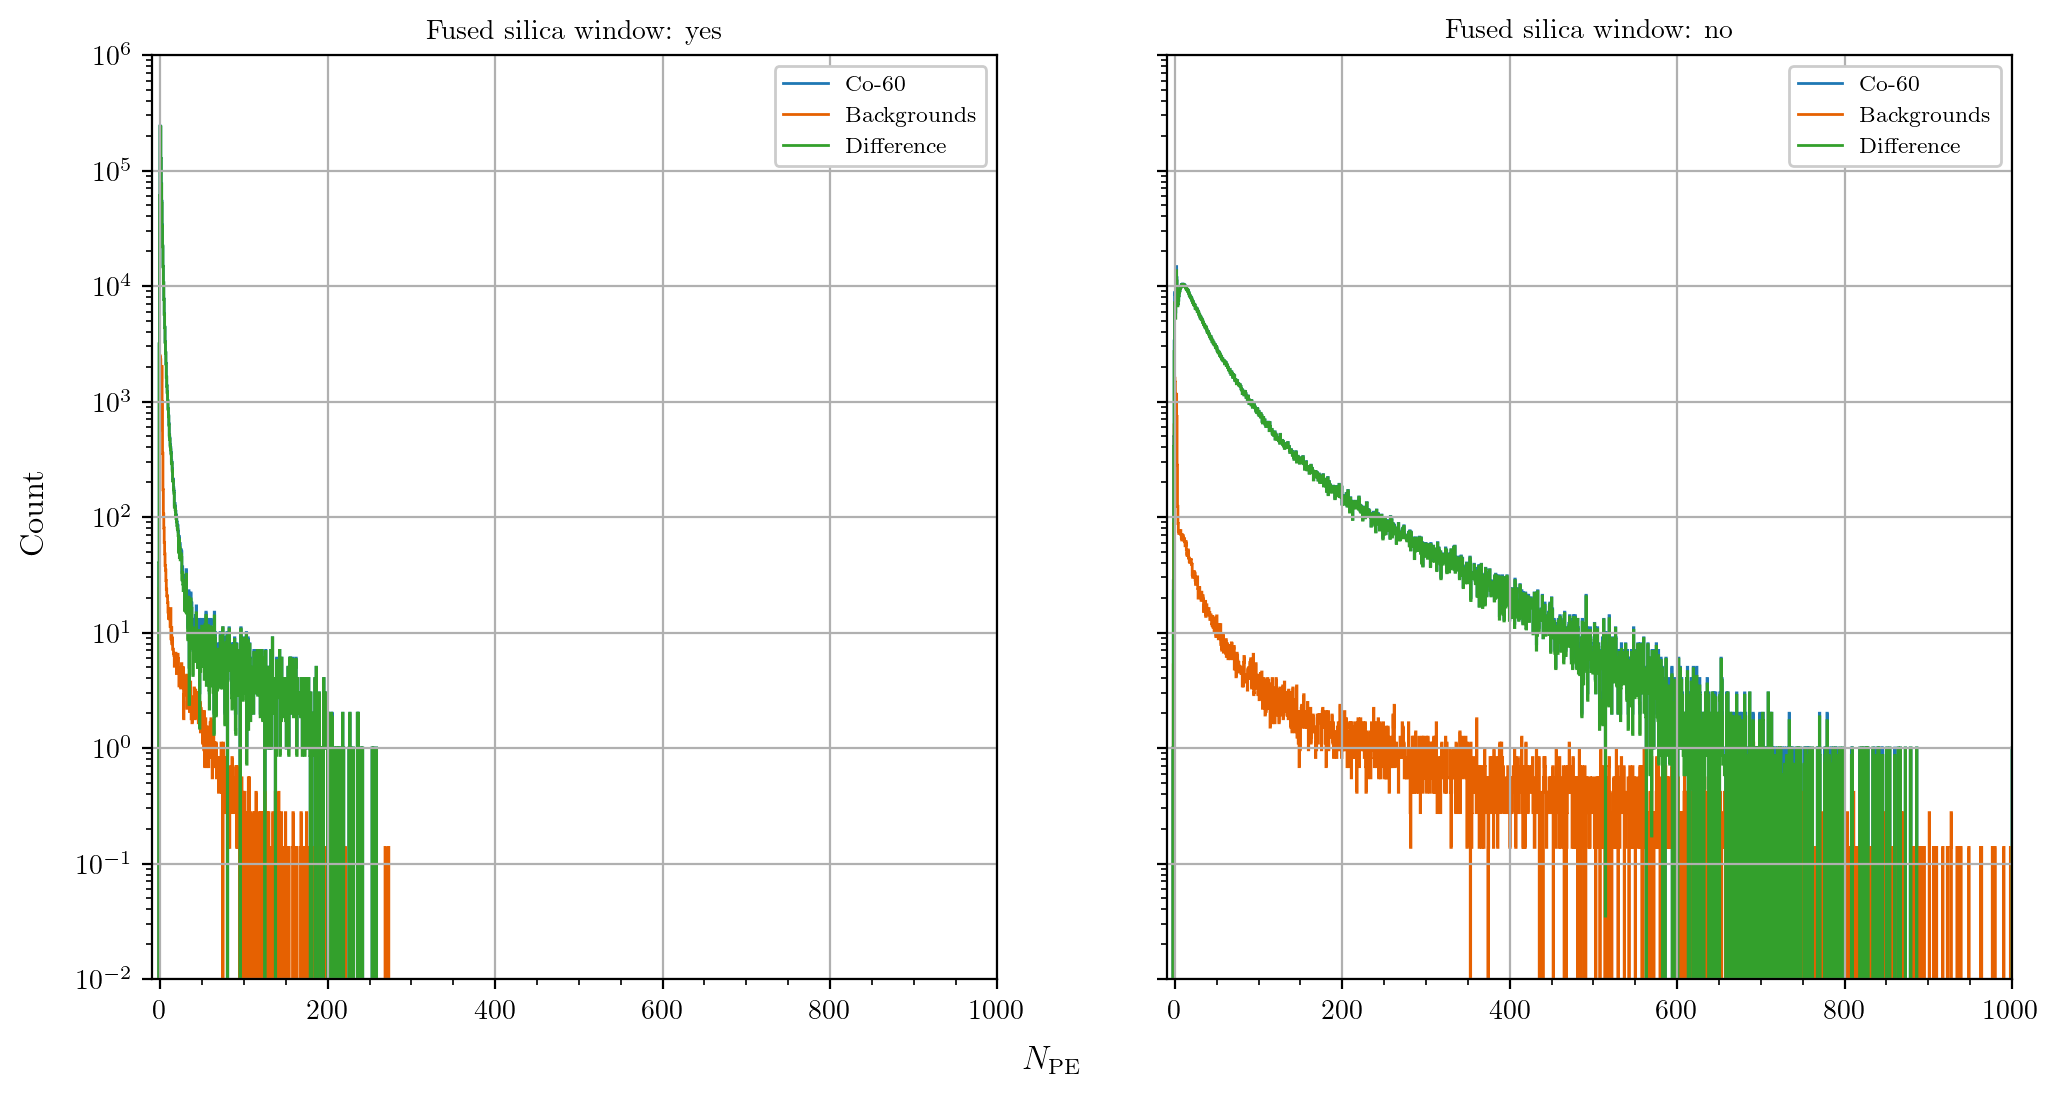

In [25]:
# Make plots for all datasets
# With source, without source, and background subtracted
fig, axs = plt.subplots(1, 2, sharex=False, sharey=True)
fig.set_size_inches(12, 6)
for j, w in enumerate(window):
    for i, c in enumerate(cond):
        axs[j].stairs(
            spectra[c][w]['counts'],
            spectra[c][w]['bins'],
            label=f'{c}', color=f'C{i}'
        )
    axs[j].stairs(spectra['Co-60'][w]['counts']-spectra['Backgrounds'][w]['counts'], 
                  spectra['Co-60'][w]['bins'], label='Difference', color='C2')
    axs[j].legend(loc='upper right')
    axs[j].set_ylim(1e-2, 1e6)
    axs[j].set_xlim(-10, 1000)
    axs[j].set_yscale('log')
    axs[j].minorticks_on()
    axs[j].grid()
    axs[j].set_title(f'Fused silica window: {w}')
fig.supxlabel(r'$N_{\rm PE}$', y=0.03)
fig.supylabel('Count', x=0.07)

## Spectra grouped by number of channels fired

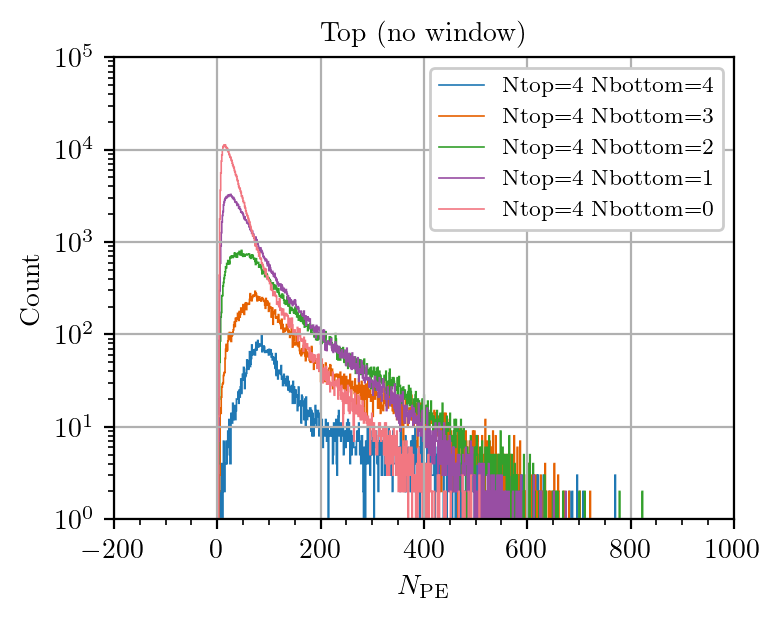

In [26]:
hist_grouped_top = data[cond[0]].groupby(['nch_top','nch_bot']).apply(lambda x: np.histogram(x['top_pe'][x['all_filt']], bins=np.linspace(-50,1000,1000)))
plt.stairs(hist_grouped_top.loc[(4,4)][0], hist_grouped_top.loc[(4,4)][1], label='Ntop=4 Nbottom=4', linewidth=0.6)
plt.stairs(hist_grouped_top.loc[(4,3)][0], hist_grouped_top.loc[(4,3)][1], label='Ntop=4 Nbottom=3', linewidth=0.6)
plt.stairs(hist_grouped_top.loc[(4,2)][0], hist_grouped_top.loc[(4,2)][1], label='Ntop=4 Nbottom=2', linewidth=0.6)
plt.stairs(hist_grouped_top.loc[(4,1)][0], hist_grouped_top.loc[(4,1)][1], label='Ntop=4 Nbottom=1', linewidth=0.6)
plt.stairs(hist_grouped_top.loc[(4,0)][0], hist_grouped_top.loc[(4,0)][1], label='Ntop=4 Nbottom=0', linewidth=0.6)
plt.minorticks_on()
plt.grid()
plt.yscale('log')
plt.xlabel(r'$N_{\rm PE}$')
plt.ylabel('Count')
plt.title('Top (no window)')
plt.legend(loc='upper right')

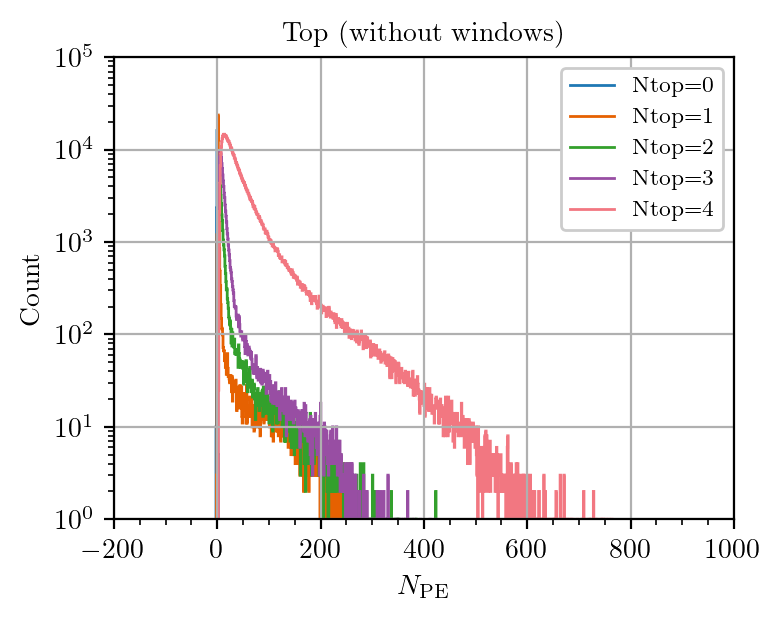

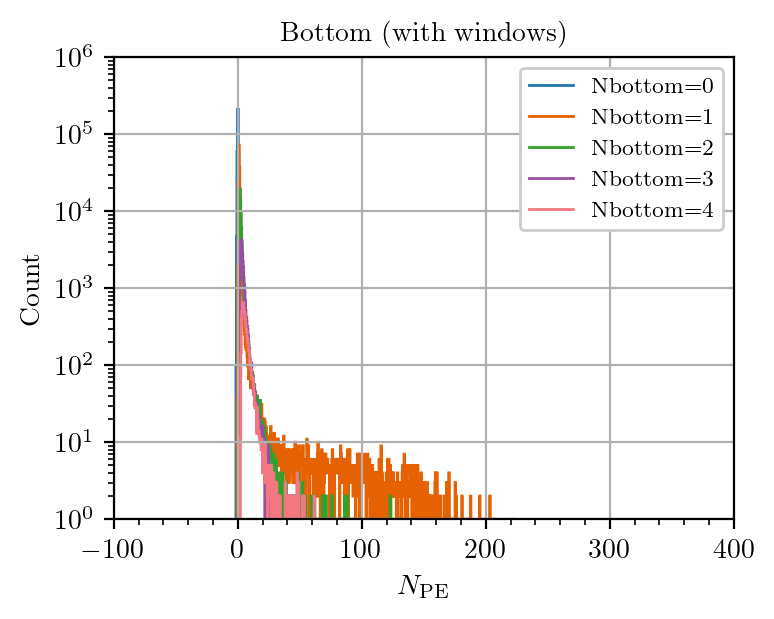

In [27]:
hist_grouped_top = data[cond[0]].groupby('nch_top').apply(lambda x: np.histogram(x['top_pe'][x['all_filt']], bins=np.linspace(-50,1000,1000)))
hist_grouped_bot = data[cond[0]].groupby('nch_bot').apply(lambda x: np.histogram(x['bot_pe'][x['all_filt']], bins=np.linspace(-50,400,1000)))
hist_grouped_top_bkg = data[cond[1]].groupby('nch_top').apply(lambda x: np.histogram(x['top_pe'][x['all_filt']], bins=np.linspace(-50,1000,1000)))
hist_grouped_bot_bkg = data[cond[1]].groupby('nch_bot').apply(lambda x: np.histogram(x['bot_pe'][x['all_filt']], bins=np.linspace(-50,400,1000)))
for i in hist_grouped_top.index:
    plt.figure(0)
    plt.stairs(hist_grouped_top.loc[i][0], hist_grouped_top.loc[i][1]-hist_grouped_top_bkg.loc[i][1]*bkg_scale, label=f'Ntop={i:.0f}')
    plt.yscale('log')
    plt.minorticks_on()
    plt.grid()
    plt.legend(loc='upper right')
    plt.title('Top (without windows)')
    plt.xlabel(r'$N_{\rm PE}$')
    plt.ylabel(r'Count')
for i in hist_grouped_bot.index:
    plt.figure(1)
    plt.stairs(hist_grouped_bot.loc[i][0], hist_grouped_bot.loc[i][1]-hist_grouped_bot_bkg.loc[i][1]*bkg_scale, label=f'Nbottom={i:.0f}')
    plt.yscale('log')
    plt.minorticks_on()
    plt.grid()
    plt.legend(loc='upper right')
    plt.title('Bottom (with windows)')
    plt.xlabel(r'$N_{\rm PE}$')
    plt.ylabel(r'Count')

## G4DS simulation (Compton scattering + UV photon transport)

Text(0, 0.5, 'Count')

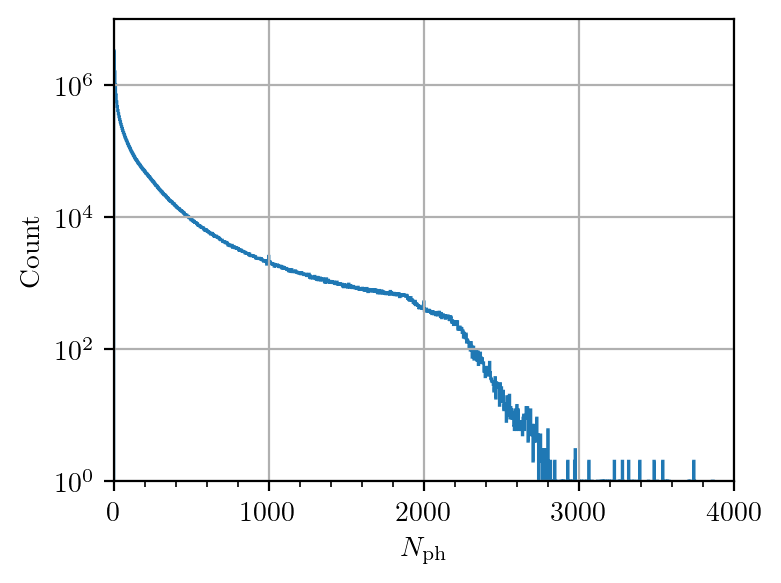

In [31]:
rtf = uproot.open('data/pu_lar_co60_hist.root')
hist_sim_top = rtf['npe_no_window'].to_numpy()
hist_sim_bot = rtf['npe_window'].to_numpy()
plt.stairs(hist_sim_top[0],hist_sim_top[1])
plt.grid()
plt.minorticks_on()
plt.yscale('log')
plt.xlabel(r'$N_{\rm ph}$')
plt.ylabel('Count')

## G4DS simulation (energy deposition only)

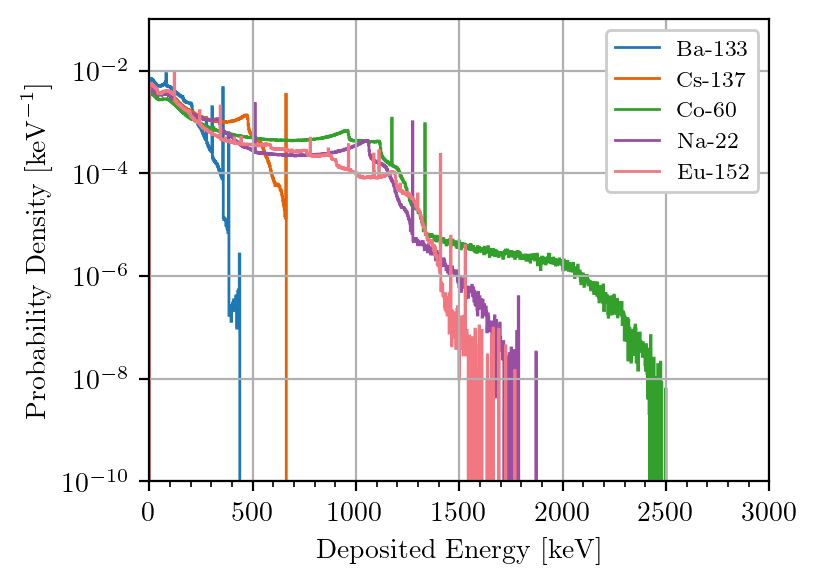

In [32]:
dir_gamma = 'data/gamma/'
files_gamma = ['spectrum_ba133_ene.root','spectrum_cs137_ene.root','spectrum_co60_ene.root','spectrum_na22_ene.root','spectrum_eu152_ene.root']
gammas = ['Ba-133','Cs-137','Co-60','Na-22','Eu-152']
for f,g in zip(files_gamma,gammas):
    root_file = ROOT.TFile.Open(f"{dir_gamma}{f}", "read")
    root_hist = root_file.Get("hEne")
    bins_ene =[]
    rates_ene = []
    for i in range(1,root_hist.GetNbinsX()+1):
        bins_ene.append(root_hist.GetBinLowEdge(i))
        rates_ene.append(root_hist.GetBinContent(i))
    bins_ene.append(bins_ene[-1]+root_hist.GetBinWidth(1))
    bins_ene = np.array(bins_ene)
    rates_ene = np.array(rates_ene)
    rates_ene /= np.sum(rates_ene)*root_hist.GetBinWidth(1)
    plt.stairs(rates_ene, bins_ene,label=g)
plt.legend(loc='upper right')
plt.yscale('log')
plt.ylabel(r'Probability Density [$\rm{keV}^{-1}$]')
plt.ylim(1e-10,1e-1)
plt.xlim(0,3000)
plt.xlabel('Deposited Energy [keV]')
plt.grid()
plt.minorticks_on()

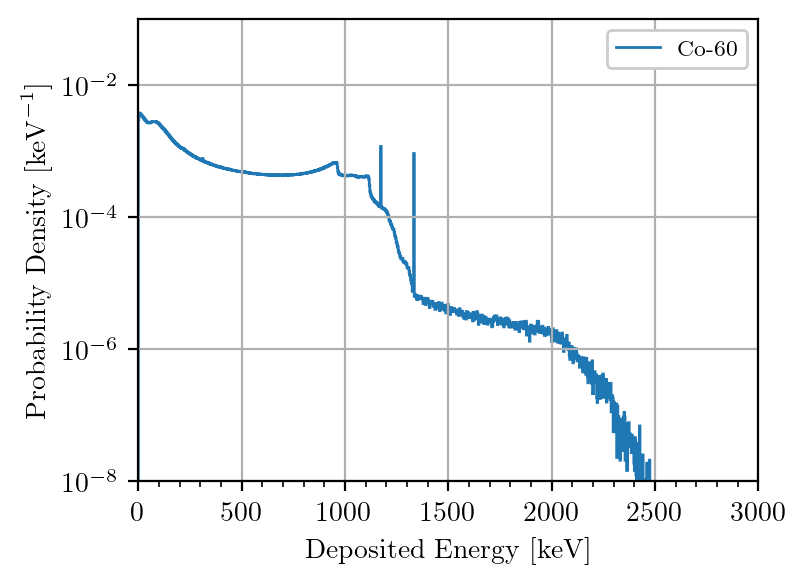

In [34]:
dir_gamma = 'data/gamma/'
files_gamma = ['spectrum_co60_ene.root']
gammas = ['Co-60']
for f,g in zip(files_gamma,gammas):
    root_file = ROOT.TFile.Open(f"{dir_gamma}{f}", "read")
    root_hist = root_file.Get("hEne")
    bins_ene =[]
    rates_ene = []
    for i in range(1,root_hist.GetNbinsX()+1):
        bins_ene.append(root_hist.GetBinLowEdge(i))
        rates_ene.append(root_hist.GetBinContent(i))
    bins_ene.append(bins_ene[-1]+root_hist.GetBinWidth(1))
    bins_ene = np.array(bins_ene)
    rates_ene = np.array(rates_ene)
    rates_ene /= np.sum(rates_ene)*root_hist.GetBinWidth(1)
    plt.stairs(rates_ene, bins_ene,label=g)
plt.legend(loc='upper right')
plt.yscale('log')
plt.ylabel(r'Probability Density [$\rm{keV}^{-1}$]')
plt.ylim(1e-8,1e-1)
plt.xlim(0,3000)
plt.xlabel('Deposited Energy [keV]')
plt.grid()
plt.minorticks_on()

## Detector response model
The number of PE follows the distribution
$$N_{\rm PE} \sim \mathcal{N}(\mu=N_{\rm ph}\times\varepsilon_p S_y/S_y^0, \sigma=\sqrt{F\mu + \alpha^2 \mu^2}),$$
where $N_{\rm ph}$ is the number of photons arriving at the SiPMs (from G4DS), $\varepsilon_p$ is the SiPMs' photo-detection efficiency (PDE), $S_y^0$ is the nominal (maximum) LAr scintillation yield $1ph/19.5eV=51.3ph/keV$ (default in G4DS), $S_y$ is the true scintillation yield ($\approx 40ph/keV$ for LAr), $F$ is the Fano factor of the SiPMs due to correlated avalanches, and $\alpha$ is a smearing factor accounting for scintillation directionality.

In [35]:
class DetectorSmearing():
    def __init__(self, pde, fano, hist_in):
        self.hist_in_bin = hist_in[1]
        self.hist_in_width = self.hist_in_bin[1]-self.hist_in_bin[0]
        self.hist_in_count = hist_in[0]/np.sum(hist_in[0])/self.hist_in_width # normalized
        self.fano = fano
        self.pde = pde

    def response_matrix(self, pe_in, pe_out, smear2):
        pe_det = self.pde*pe_in
        return norm.pdf(pe_out, loc=self.pde*pe_in, scale=np.sqrt(self.fano*pe_det + smear2**2*pe_det**2))

    def get_spectrum(self, bins, n, smear2):
        self.hist_out_bin = bins
        bin_cen_in = (self.hist_in_bin[1:]+self.hist_in_bin[:-1])/2
        bin_cen_out = (self.hist_out_bin[1:]+self.hist_out_bin[:-1])/2
        pe_out_mesh, pe_in_mesh = np.meshgrid(bin_cen_out, bin_cen_in)
        self.hist_out_count = self.hist_in_count @ self.response_matrix(pe_in_mesh, pe_out_mesh, smear2)
        return n*self.hist_out_count, self.hist_out_bin
        
    def fit_to_data(self, data, sigma, x0, fit_range):
        def residual(x, *args, **kwargs):
            n, smear2 = x[0], x[1]
            data_y, data_bin = args[0], args[1]
            bincen = (data_bin[1:] + data_bin[:-1])/2
            ans = (data_y-self.get_spectrum(data_bin, n, smear2)[0])
            sigma[sigma==0] = 1
            ans = ans/sigma
            mask = (bincen<fit_range[1]) & (bincen>fit_range[0])
            return ans[mask]
        res = least_squares(residual,x0=x0,args=data,bounds=(0,np.inf))
        return res.x
        

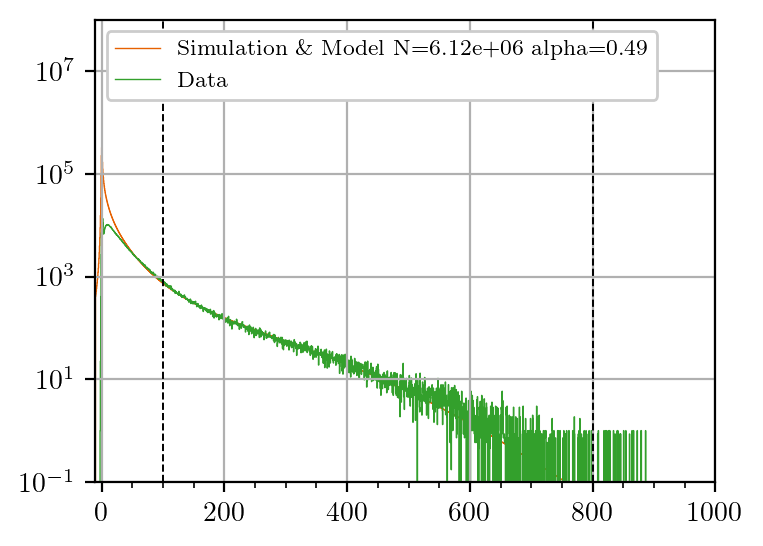

In [36]:
fit_range = (100,800)
ymin, ymax = 1e-1,1e8
smear = DetectorSmearing(pde=0.175*4/5,fano=1.05,hist_in=hist_sim_top)
par = smear.fit_to_data(
    data=(spectra['Co-60']['no']['counts']-spectra['Backgrounds']['no']['counts'],spectra['Co-60']['no']['bins']),
    sigma=spectra['Co-60']['no']['errs'],
    x0=[1e6,0.5],
    fit_range=fit_range
)
plt.stairs(*(smear.get_spectrum(spectra['Co-60']['no']['bins'],*par)), label='Simulation \& Model '+f'N={par[0]:.2e} alpha={par[1]:.2f}', color='C1', linewidth=0.5)
plt.stairs(spectra['Co-60']['no']['counts']-spectra['Backgrounds']['no']['counts'],spectra['Co-60']['no']['bins'], label='Data', color='C2', linewidth=0.5)
plt.plot([fit_range[0]]*2,[ymin,ymax],'k--',linewidth=0.7)
plt.plot([fit_range[1]]*2,[ymin,ymax],'k--',linewidth=0.7)
plt.yscale('log')
plt.minorticks_on()
plt.grid()
plt.ylim(1e-1,1e8)
plt.xlim(-10,1000)
plt.legend()